# Approfondissement ElasticSearch pour des recherches de proximité

géographique

Pour essayer les exemples présents dans ce tutoriel :

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter.png)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter.png)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python.png)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/modern-ds%20elastic_approfondissement.ipynb%C2%BB&security.allowlist.enabled=false)<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=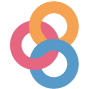.png)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modern-ds/elastic_approfondissement.ipynb)
[![githubdev](https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc.png)](https://github.dev/linogaliana/python-datascientist/notebooks/course/modern-ds/elastic_approfondissement.ipynb)

Ce chapitre est issu du travail produit
dans le cadre d’un hackathon de l’Insee avec
[Raphaële Adjerad](https://github.com/raphaeleadjerad)
et présente quelques éléments qui peuvent être utiles
pour l’enrichissement de données d’entreprises
à partir d’un répertoire officiel.

:warning: Il nécessite une version particulière du package `elasticsearch` pour tenir compte de l’héritage de la version 7 du moteur Elastic. Pour cela, faire

``` python
pip install elasticsearch==8.2.0
```

# Introduction

Dans le cadre particulier de l’identification des entreprises, Elasticsearch fait partie de la solution retenue par
l’API “Sirene données ouvertes” (DINUM) (cf https://annuaire-entreprises.data.gouv.fr/) l’API de recherche d’entreprises Française de la Fabrique numérique des Ministères Sociaux (cf https://api.recherche-entreprises.fabrique.social.gouv.fr/)le projet de l’Insee “Amélioration de l’identification de l’employeur dans le recensement”, pour faire une première sélection des établissements pertinents pour un bulletin de recensement donné.
Dans le cadre de l’identification des individus, Elasticsearch fait partie de la solution envisagée pour l’identification des individus au RNIPP (Répertoire national des personnes physiques) pour le projet CSNS (Code statistique non signifiant), et est la solution technique sous-jacente au projet matchID du ministère de l’intérieur.

Au delà du secteur public, on peut citer qu’Amazon AWS fait partie des utilisateurs historiques d’Elasticsearch.

## Objectif

Ce chapitre vise à approfondir les éléments présentés sur Elastic précédemment. L’idée
est de se placer dans un contexte opérationnel où on reçoit des informations
sur des entreprises telles que l’adresse et la localisation et qu’on
désire associer à des données administratives considérées plus fliables.

## Réplication de ce chapitre

Comme le précédent, ce chapitre est plus exigeant en termes d’infrastructures que les précédents.
Il nécessite un serveur Elastic. Les utilisateurs du
[SSP Cloud](datalab.sspcloud.fr/) pourront répliquer les exemples de ce cours
car cette technologie est disponible (que ce soit pour indexer une base ou
pour requêter une base existante).

La première partie de ce tutoriel, qui consiste à créer une base Sirene géolocalisée
à partir des données *open-data* ne nécessite pas d’architecture particulière et
peut ainsi être exécutée en utilisant les packages suivants:

In [2]:
import numpy as np
import pandas as pd

## Sources

Ce chapitre va utiliser plusieurs sources de diffusion de
l’Insee:

-   Le stock des établissements présents dans les [données de diffusion Sirene](https://www.insee.fr/fr/information/3591226) ;
-   Les [données Sirene géolocalisées](https://www.data.gouv.fr/fr/datasets/geolocalisation-des-etablissements-du-repertoire-sirene-pour-les-etudes-statistiques/)

Les données à siretiser sont celles du registre Français des émissions polluantes
établi par le Ministère de la Transition Energétique. Le jeu de données
est disponible sur [data.gouv](https://www.data.gouv.fr/fr/datasets/registre-francais-des-emissions-polluantes/)

# Préparation des données à identifier

Le jeu de données présente déjà
l’identifiant
de l’établissement, dit numéro `siret`.
Nous allons faire comme si nous étions
en amont de cet appariement et que nous
désirons trouver ce numéro. La présence
dans la base de ce numéro nous permettra d’évaluer la qualité
de notre méthode de recherche avec
`Elastic`.

In [3]:
import requests
import zipfile
import pandas as pd

url = "https://www.data.gouv.fr/fr/datasets/r/9af639b9-e2b6-4d7d-8c5f-0c4953c48663"
req = requests.get(url)

with open("irep.zip",'wb') as f:
  f.write(req.content)

with zipfile.ZipFile("irep.zip", 'r') as zip_ref:
  zip_ref.extractall("irep")

etablissements = pd.read_csv("irep/2019/etablissements.csv", sep = ";")

# Constitution du référentiel administratif géolocalisé

Dans un premier temps, on va combiner ensemble les différentes sources
*open-data* pour créer un référentiel fiable d’entreprises
géolocalisées.

## Importer la base déjà créée

Les données à utiliser pour constuire une base Sirene géolocalisée
sont trop volumineuses pour les serveurs mis à disposition
gratuitement par `Github` pour la compilation de ce site web.
Nous proposons ainsi une version déjà construite, stockée
dans l’espace de mise à disposition du SSP Cloud. Ce fichier est
au format `parquet` et est ouvert à
tous, même pour les personnes ne disposant pas d’un compte.
Le code ayant construit cette base est présenté ci-dessous.

Pour importer cette base, on utilise les fonctionalités
de `pyarrow` qui permettent d’importer un fichier sur
un système de stockage *cloud* comme s’il était
présent sur le disque :

In [4]:
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq

bucket = "lgaliana"
path = "diffusion/sirene_geolocalized.parquet"

s3 = fs.S3FileSystem(endpoint_override="http://"+"minio.lab.sspcloud.fr")

df_geolocalized = pq.ParquetDataset(f'{bucket}/{path}', filesystem=s3).read_pandas().to_pandas()
df_geolocalized.head(3)

## Reproduire la construction de la base

La première base d’entrée à utiliser est disponible sur
[data.gouv](https://www.data.gouv.fr/fr/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/)

In [5]:
import requests
import zipfile

url_download = "https://www.data.gouv.fr/fr/datasets/r/0651fb76-bcf3-4f6a-a38d-bc04fa708576"
req = requests.get(url_download)

with open("sirene.zip",'wb') as f:
  f.write(req.content)

with zipfile.ZipFile("sirene.zip", 'r') as zip_ref:
  zip_ref.extractall("sirene")

On va importer seulement les colonnes utiles et simplifier la structure
pour être en mesure de ne garder que les informations qui nous
intéressent (nom de l’entreprise, adresse, commune, code postal…)

In [6]:
import pandas as pd
import numpy as np

list_cols = [
  'siren', 'siret',
  'activitePrincipaleRegistreMetiersEtablissement',
  'complementAdresseEtablissement',
  'numeroVoieEtablissement',
  'typeVoieEtablissement',
  'libelleVoieEtablissement',
  'codePostalEtablissement',
  'libelleCommuneEtablissement',
  'codeCommuneEtablissement',
  'etatAdministratifEtablissement',
  'denominationUsuelleEtablissement',
  'activitePrincipaleEtablissement'
]

df = pd.read_csv(
  "sirene/StockEtablissement_utf8.csv",
  usecols = list_cols)

df['numero'] = df['numeroVoieEtablissement']\
  .replace('-', np.NaN).str.split().str[0]\
  .str.extract('(\d+)', expand=False)\
  .fillna("0").astype(int)

df['numero'] = df['numero'].astype(str).replace("0","")

df['adresse'] = df['numero'] + " " + \
  df['typeVoieEtablissement'] + " " + \
  df['libelleVoieEtablissement']

df['adresse'] = df['adresse'].replace(np.nan, "")

df = df.loc[df['etatAdministratifEtablissement'] == "A"]

df.rename(
  {"denominationUsuelleEtablissement": "denom",
  "libelleCommuneEtablissement": "commune",
  "codeCommuneEtablissement" : "code_commune",
  "codePostalEtablissement": "code_postal"},
  axis = "columns", inplace = True)

df['ape'] = df['activitePrincipaleEtablissement'].str.replace("\.", "", regex = True)
df['denom'] = df["denom"].replace(np.nan, "")

df_siret = df.loc[:, ['siren', 'siret','adresse', 'ape', 'denom', 'commune', 'code_commune','code_postal']]
df_siret['code_postal'] = df_siret['code_postal'].replace(np.nan, "0").astype(int).astype(str).replace("0","")

On importe ensuite les données géolocalisées

In [7]:
import zipfile
import shutil
import os

#os.remove("sirene.zip")
#shutil.rmtree('sirene/')

url_geoloc = "https://files.data.gouv.fr/insee-sirene-geo/GeolocalisationEtablissement_Sirene_pour_etudes_statistiques_utf8.zip"
r = requests.get(url_geoloc)  

with open('geoloc.zip', 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile("geoloc.zip", 'r') as zip_ref:
  zip_ref.extractall("geoloc")

df_geoloc = pd.read_csv(
  "geoloc/GeolocalisationEtablissement_Sirene_pour_etudes_statistiques_utf8.csv",
  usecols = ["siret", "epsg", "x_longitude", "y_latitude"] , sep = ";")

Il ne reste plus qu’à associer les deux jeux de données

In [8]:
df_geolocalized = df_siret.merge(df_geoloc, on = "siret") 
df_geolocalized['code_commune'] = df_geolocalized['code_commune'].astype(str) 

Si vous avez accès à un espace de stockage cloud de type
`S3`, il est possible d’utiliser `pyarrow` pour enregister
cette base. Afin de l’enregistrer dans un espace de stockage
public, nous allons l’enregistrer dans un dossier `diffusion`[1]

[1] Concernant la première piste, il aurait
fallu mieux définir notre mapping pour
autoriser des *analyzers*. A défaut,
nous pourrons
utiliser `nltk` ou `spacy` pour transformer
les champs textuels avant d’envoyer la requête.
Cette solution présente l’inconvénient
de ne pas formatter de la même manière l’ensemble
indexé mais pourrait malgré tout améliorer la pertinence
des recherches.

In [9]:
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq

bucket = "lgaliana"
path = "diffusion/sirene_geolocalized.parquet"

s3 = fs.S3FileSystem(endpoint_override="http://"+"minio.lab.sspcloud.fr")

table = pa.Table.from_pandas(df_geolocalized)

# Connexion à ElasticSearch

On va supposer que l’utilisateur dispose déjà d’un serveur Elastic
fonctionnel mais désire créer un nouvel index. Si vous utilisez
le SSPCloud, la démarche de création d’un service
Elastic est disponible dans le chapitre précédent.

In [10]:
from elasticsearch import Elasticsearch
HOST = 'elasticsearch-master'

def elastic():
    """Connection avec Elastic sur le data lab"""
    es = Elasticsearch([{'host': HOST, 'port': 9200, 'scheme': 'http'}], http_compress=True, request_timeout=200)
    return es

es = elastic()
es

    <Elasticsearch(['http://elasticsearch-master:9200'])>

# Indexation de notre base Sirène géolocalisée

## Définition du mapping

On va procéder par étape en essayant d’utiliser la structure la plus simple
possible.

:one: On s’occupe d’abord de définir le *mapping*
pour les variables textuelles.

In [11]:
string_var = ["adresse", "denom", "ape", "commune"]
map_string = {"type": "text", "fields": {"keyword": {"type": "keyword", "ignore_above": 256}}}
mapping_string = {l: map_string for l in string_var}

:two: Les variables catégorielles sont utilisées
par le biais du type `keyword`:

In [12]:
# keywords
keyword_var = ["siren","siret","code_commune","code_postal"]
map_keywords = {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}}}
mapping_keywords = {l: map_keywords for l in keyword_var}

:three: La nouveauté par rapport à la partie
précédente est l’utilisation de la
dimension géographique. `Elastic` propose
le type `geo_point` pour cela.

In [13]:
# geoloc
mapping_geoloc = {
  "location": {
    "type": "geo_point"
    }
}    

On collecte tout cela ensemble dans un
dictionnaire:

In [14]:
# mapping
mapping_elastic = {"mappings":
  {"properties":
    {**mapping_string, **mapping_geoloc, **mapping_keywords}
  }
}

Il est tout à fait possible de définir un *mapping*
plus raffiné. Ici, on va privilégier
l’utilisation d’un *mapping* simple pour
illustrer la recherche par distance
géographique en priorité.

## Création de l’index

Pour créer le nouvel index, on s’assure d’abord de ne pas
déjà l’avoir créé et on passe le *mapping* défini
précédemment.

In [15]:
if es.indices.exists('sirene'):
    es.indices.delete('sirene')

es.indices.create(index = "sirene", body = mapping_elastic)   

## Indexation de la base géolocalisée

Pour le moment, l’index est vide. Il convient de
le peupler.

Il est néanmoins nécessaire de créer le champ `location`
au format attendu par elastic: `lat, lon` à partir
de nos colonnes.

In [16]:
df_geolocalized['location'] = df_geolocalized['y_latitude'].astype(str) + ", " + df_geolocalized['x_longitude'].astype(str)

La fonction suivante permet de structurer chaque
ligne du `DataFrame` telle qu’Elastic l’attend:

In [17]:
def gen_dict_from_pandas(index_name, df):
    '''
    Lit un dataframe pandas Open Food Facts, renvoi un itérable = dictionnaire des données à indexer, sous l'index fourni
    '''
    for i, row in df.iterrows():
        header= {"_op_type": "index","_index": index_name,"_id": i}
        yield {**header,**row}

Enfin, on peut industrialiser l’indexation
de notre `DataFrame` en faisant tourner de
manière successive cette fonction:

In [18]:
from elasticsearch.helpers import bulk, parallel_bulk
from collections import deque
deque(parallel_bulk(client=es, actions=gen_dict_from_pandas("sirene", df_geolocalized), chunk_size = 1000, thread_count = 4))

In [19]:
es.count(index = 'sirene')

    ObjectApiResponse({'count': 13059694, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

# Recherche

Pour se faciliter la création de cartes
réactives, nous allons régulièrement
utiliser la fonction suivante qui s’appuie
sur un code déjà présenté dans un autre
chapitre.

In [20]:
def plot_folium_sirene(df, yvar, xvar):

    center = df[[yvar, xvar]].mean().values.tolist()
    sw = df[[yvar, xvar]].min().values.tolist()
    ne = df[[yvar, xvar]].max().values.tolist()

    m = folium.Map(location = center, tiles='Stamen Toner')

    # I can add marker one by one on the map
    for i in range(0,len(df)):
        folium.Marker(
            [df.iloc[i][yvar], df.iloc[i][xvar]],
            popup = df.iloc[i]["_source.denom"] + f'<br>(Score: {df.iloc[i]["_score"]:.2f})',
            icon=folium.Icon(icon="home")
        ).add_to(m)

    m.fit_bounds([sw, ne])

    return m

## Premier exemple de requête géographique

In [21]:
ex1 = es.search(index = 'sirene', body = '''{
  "query": {
    "bool": {
      "must":
      { "match": { "denom":   "institut national de la statistique"}}
      }
  }
}
''')['hits']['hits']

echo_insee = pd.json_normalize(ex1)
echo_insee

On remarque déjà que les intitulés ne sont
pas bons. Quand est-il de leurs localisations ?

In [22]:
plot_folium_sirene(
  echo_insee, yvar = "_source.y_latitude",
  xvar = "_source.x_longitude")

Ce premier essai nous suggère qu’il est
nécessaire d’améliorer notre recherche.
Plusieurs voies sont possibles:

1.  Améliorer le preprocessing de nos champs
    textuels en excluant, par exemple, les
    stopwords ;
2.  Effectuer une restriction géographique
    pour mieux cibler l’ensemble de recherche
3.  Trouver une variable catégorielle jouant
    le rôle de variable de blocage[1] pour
    mieux cibler les paires pertinentes

Concernant la restriction
géographique, Elastic fournit une approche
très efficace de ciblage géographique.
En connaissant une position approximative
de l’entreprise à rechercher,
il est ainsi possible de
rechercher dans un rayon
d’une taille plus ou moins grande.
En supposant qu’on connaisse précisément
la localisation de l’Insee, on peut
chercher dans un rayon relativement
restreint. Si notre position était plus
approximative, on pourrait rechercher
dans un rayon plus large.

[1] Concernant la première piste, il aurait
fallu mieux définir notre mapping pour
autoriser des *analyzers*. A défaut,
nous pourrons
utiliser `nltk` ou `spacy` pour transformer
les champs textuels avant d’envoyer la requête.
Cette solution présente l’inconvénient
de ne pas formatter de la même manière l’ensemble
indexé mais pourrait malgré tout améliorer la pertinence
des recherches.

In [23]:
ex2 = es.search(index = 'sirene', body = '''{
  "query": {
    "bool": {
      "must":
      { "match": { "denom":   "institut national de la statistique"}}
      ,
      "filter":
        {"geo_distance": {
          "distance": "1km",
          "location": {
            "lat": "48.8168",
            "lon": "2.3099"
          }
        }
      }
    }
  }
}
''')['hits']['hits']

echo_insee = pd.json_normalize(ex2)
echo_insee

{{% box status=“hint” title=“Conseil” icon=“fa fa-lightbulb” %}}
Connaître la précision précise d’une
entreprise
nécessite déjà une bonne remontée
d’information sur celle-ci.
Il est plus plausible de supposer
qu’on dispose, dans une phase amont
de la chaine de production,
de l’adresse de celle-ci.
Dans ce cas, il est utile
d’utiliser un service de géocodage,
comme l’[API Adresse](https://adresse.data.gouv.fr/api-doc/adresse)
développée par Etalab.
{{% /box %}}

Les résultats sont par construction mieux
ciblés. Néanmoins ils sont toujours décevants
puisqu’on ne parvient pas à identifier l’Insee
dans les dix meilleurs échos.

In [24]:
specificsearch = es.search(index = 'sirus_2020', body = 
'''{
  "query": {
    "bool": {
      "should":
          { "match": { "rs_denom":   "CPCU - CENTRALE DE BERCY"}},
      "filter": [
          {"geo_distance": {
                  "distance": "0.5km",
                  "location": {
                        "lat": "48.84329", 
                        "lon": "2.37396"
                              }
                            }
            }, 
            { "prefix":  { "apet": "3530" }}
                ]
            }
          }
}'''
)